In [1]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import umap
import hdbscan


In [2]:
# --- 2. LOAD DATA ---
depth_data = pd.read_csv('/content/BNBFDUSD_20250314_depth.txt', delimiter=',')
trade_data = pd.read_csv('/content/BNBFDUSD_20250314_agg.txt', delimiter=',')


In [3]:
# --- 3. FEATURE ENGINEERING ---
def feature_engineering(depth_data, trade_data):
    features = pd.DataFrame()

    # Mid price
    features['mid_price'] = (depth_data['AskPriceL1'] + depth_data['BidPriceL1']) / 2

    # Spread
    features['spread'] = depth_data['AskPriceL1'] - depth_data['BidPriceL1']

    # Order book imbalance level 1
    features['ob_imbalance_lvl1'] = (depth_data['BidQtyL1'] - depth_data['AskQtyL1']) / \
                                    (depth_data['BidQtyL1'] + depth_data['AskQtyL1'])

    # Cumulative bid/ask quantity (depth)
    bid_cols = [col for col in depth_data.columns if 'BidQtyL' in col]
    ask_cols = [col for col in depth_data.columns if 'AskQtyL' in col]
    features['cum_bid_qty'] = depth_data[bid_cols].sum(axis=1)
    features['cum_ask_qty'] = depth_data[ask_cols].sum(axis=1)

    # Rolling returns and volatility
    features['returns'] = np.log(features['mid_price'] / features['mid_price'].shift(1))
    features['volatility_10s'] = features['returns'].rolling(window=10).std()
    features['volatility_30s'] = features['returns'].rolling(window=30).std()

    # Volume features
    features['price'] = trade_data['Price']
    features['quantity'] = trade_data['Quantity']
    features['num_trades'] = trade_data['NumTrades']

    # Derived volume features
    features['volume_imbalance'] = features['quantity'].diff()
    features['cum_volume_10s'] = features['quantity'].rolling(window=10).sum()
    features['cum_volume_30s'] = features['quantity'].rolling(window=30).sum()

    # Derived Features: Rate of Change (ROC)
    features['spread_roc'] = features['spread'].pct_change()
    features['imbalance_roc'] = features['ob_imbalance_lvl1'].pct_change()

    # Log-transform large range features
    features['log_quantity'] = np.log1p(features['quantity'])

    return features

features = feature_engineering(depth_data, trade_data)


In [4]:
# --- 3.5. CLEANING FEATURES ---
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)


In [5]:
# --- 4. NORMALIZE AND REDUCE DIMENSIONS ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


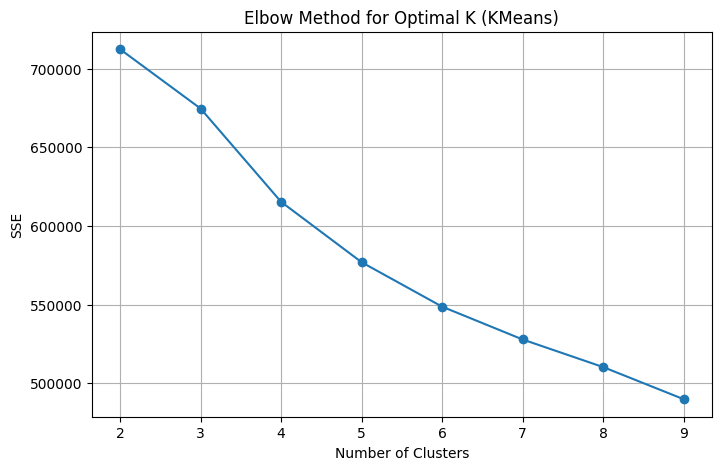

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
# --- 5. CLUSTERING METHODS ---
# KMeans
sse = []
k_list = range(2, 10)
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_list, sse, marker='o')
plt.title('Elbow Method for Optimal K (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()

# Optimal K
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
labels_kmeans = kmeans.fit_predict(X_pca)

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True)
labels_hdbscan = clusterer.fit_predict(X_pca)

# GMM
gmm = GaussianMixture(n_components=k_optimal, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)


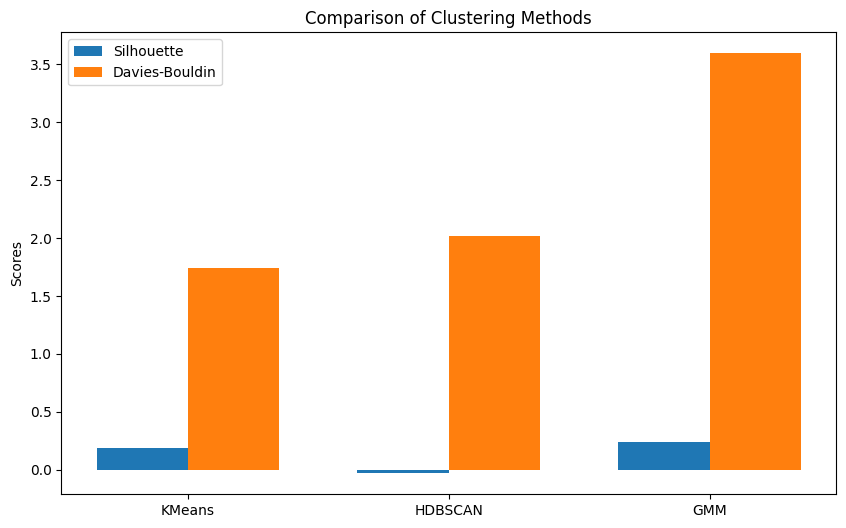

In [7]:
# --- 6. CLUSTER QUALITY METRICS ---
methods = ['KMeans', 'HDBSCAN', 'GMM']
silhouette_scores = [
    silhouette_score(X_pca, labels_kmeans),
    silhouette_score(X_pca, labels_hdbscan),
    silhouette_score(X_pca, gmm_labels)
]
davies_scores = [
    davies_bouldin_score(X_pca, labels_kmeans),
    davies_bouldin_score(X_pca, labels_hdbscan),
    davies_bouldin_score(X_pca, gmm_labels)
]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, silhouette_scores, width, label='Silhouette')
rects2 = ax.bar(x + width/2, davies_scores, width, label='Davies-Bouldin')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Clustering Methods')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
plt.show()

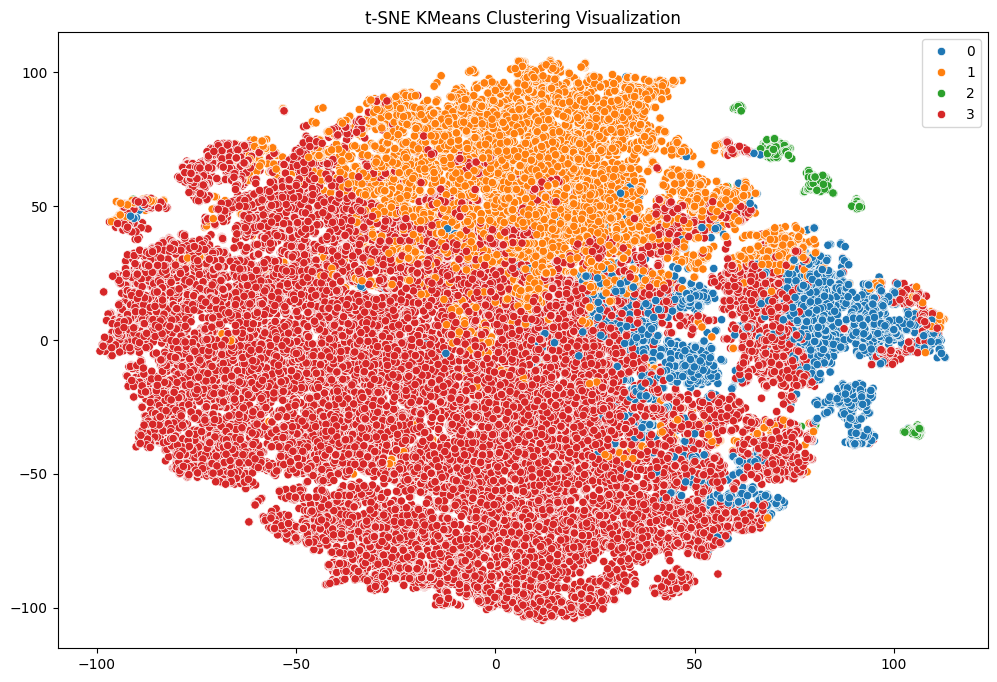

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


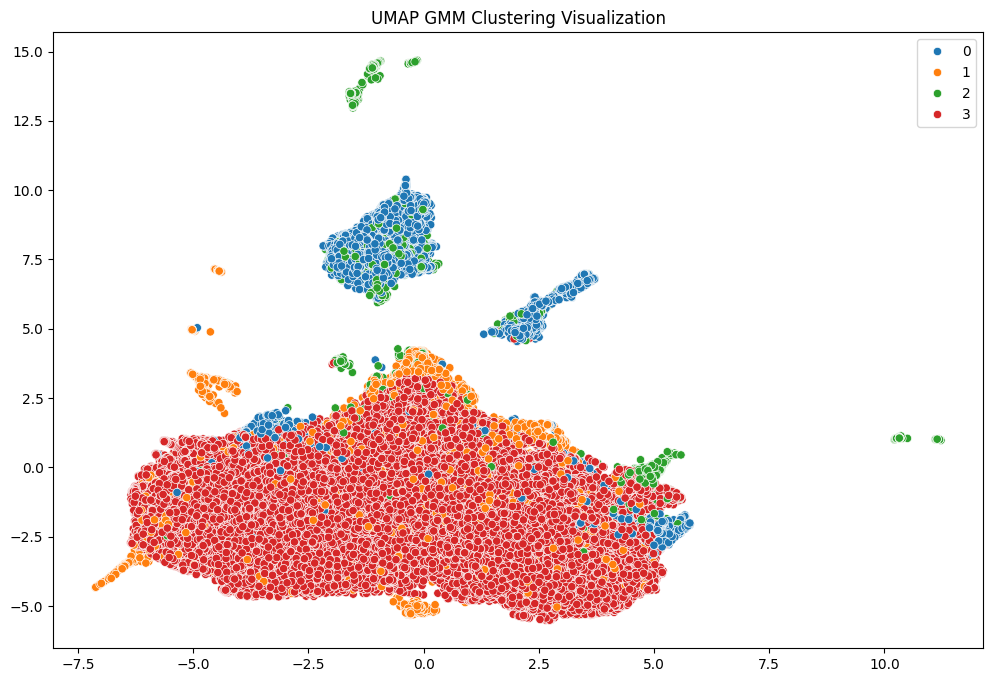

In [8]:
# --- 7. VISUALIZATION ---
# t-SNE
embedding = TSNE(n_components=2, random_state=42).fit_transform(X_pca)

plt.figure(figsize=(12,8))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels_kmeans, palette='tab10')
plt.title('t-SNE KMeans Clustering Visualization')
plt.show()

# UMAP
embedding_umap = umap.UMAP(random_state=42).fit_transform(X_pca)

plt.figure(figsize=(12,8))
sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=gmm_labels, palette='tab10')
plt.title('UMAP GMM Clustering Visualization')
plt.show()


In [9]:
# --- 8. REGIME ENRICHMENT ---
features['regime'] = labels_kmeans

regime_summary = features.groupby('regime').mean()

def categorize_regimes(summary_df):
    descriptions = {}
    for regime, row in summary_df.iterrows():
        desc = []

        # Volatile vs Stable
        desc.append("Volatile" if row['volatility_30s'] > 0.01 else "Stable")

        # Liquid vs Illiquid
        total_liquidity = row['cum_bid_qty'] + row['cum_ask_qty']
        desc.append("Liquid" if total_liquidity > 10000 else "Illiquid")

        # Trending vs Mean-Reverting (based on returns skew)
        returns = features[features['regime'] == regime]['returns']
        skew = returns.skew()
        desc.append("Trending" if abs(skew) > 0.5 else "Mean-Reverting")

        descriptions[regime] = " | ".join(desc)
    return descriptions

regime_descriptions = categorize_regimes(regime_summary)
features['regime_desc'] = features['regime'].map(regime_descriptions)


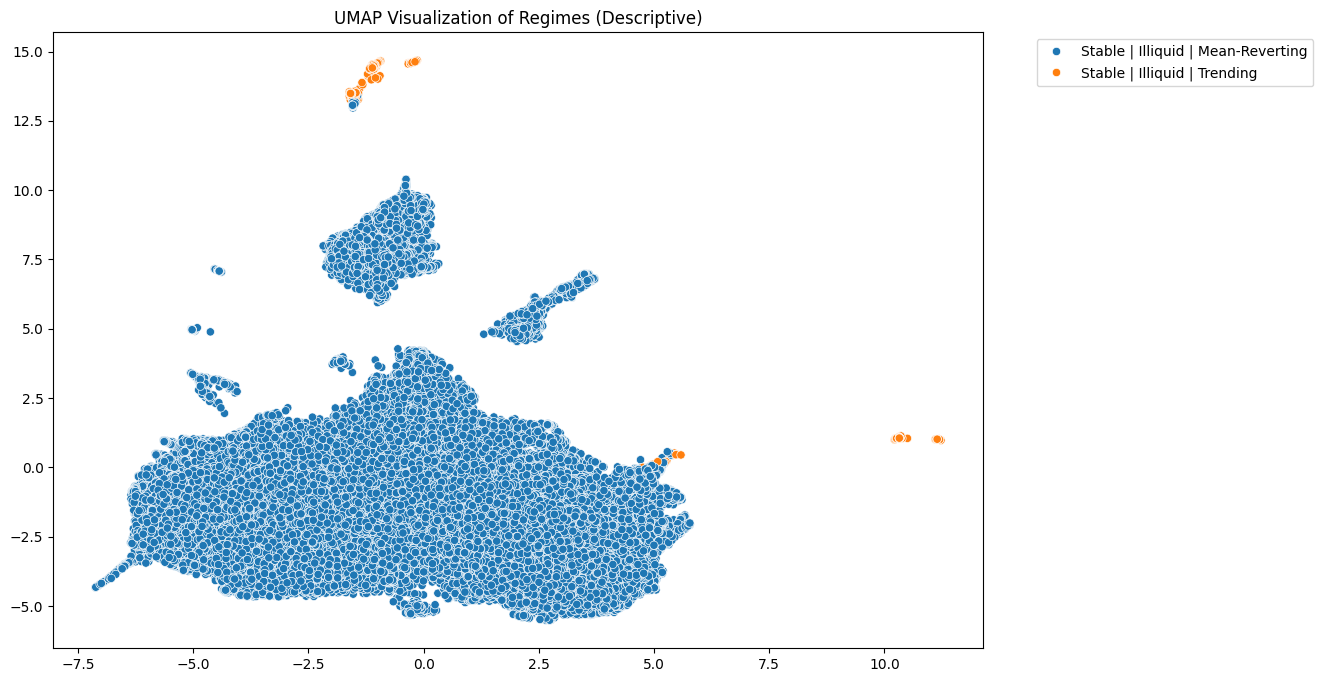

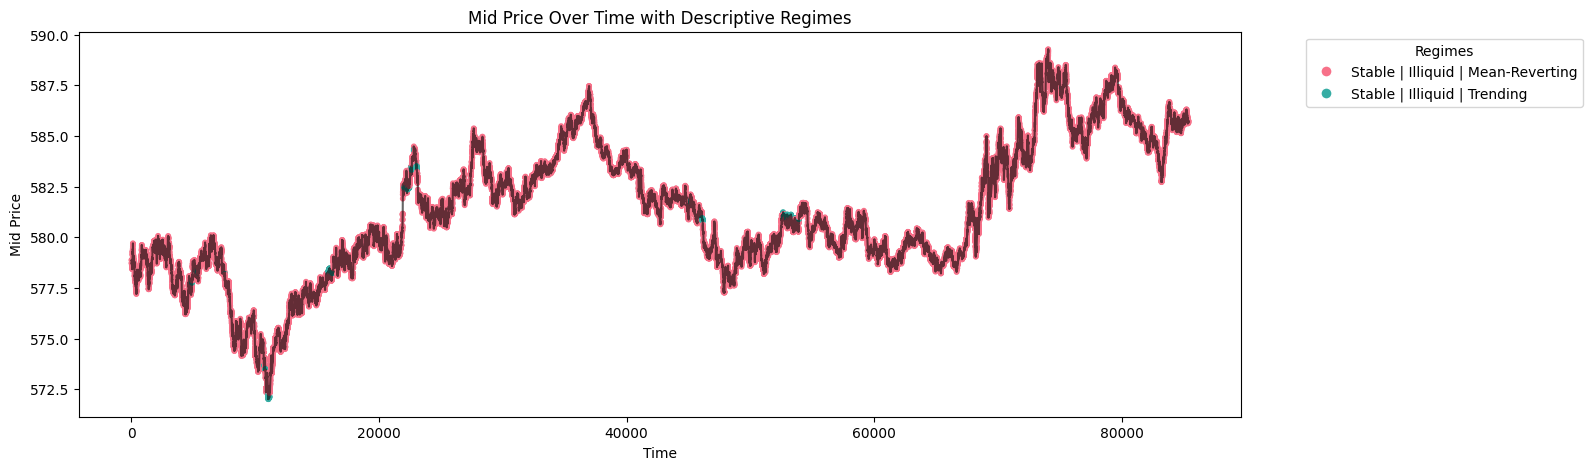

In [10]:
# --- 9. ENRICHED VISUALIZATION ---
# UMAP with descriptions
plt.figure(figsize=(12,8))
sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=features['regime_desc'], palette='tab10')
plt.title('UMAP Visualization of Regimes (Descriptive)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Time series colored by regime descriptions
plt.figure(figsize=(15,5))
unique_regimes = features['regime_desc'].unique()
palette = sns.color_palette('husl', len(unique_regimes))
color_map = dict(zip(unique_regimes, palette))
colors = features['regime_desc'].map(color_map)

plt.plot(features.index, features['mid_price'], color='black', alpha=0.6, label='Mid Price')
plt.scatter(features.index, features['mid_price'], c=colors, s=10)
plt.title('Mid Price Over Time with Descriptive Regimes')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color_map[label], markersize=8)
    for label in unique_regimes
], title='Regimes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

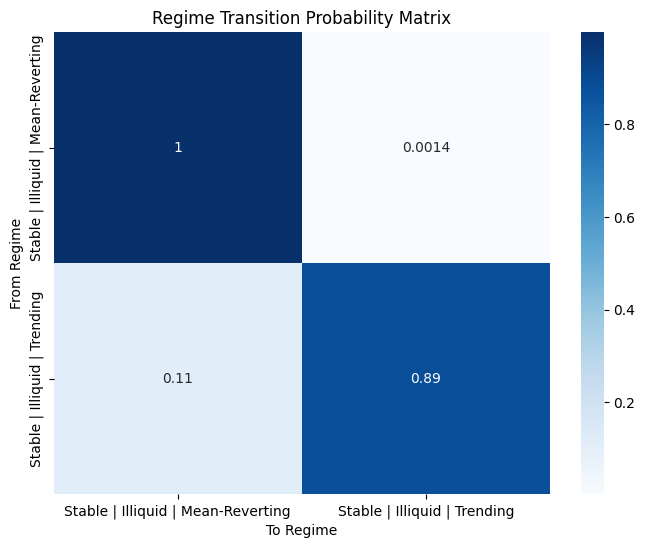

In [11]:
# --- 10. TRANSITION MATRIX ---
transitions = pd.crosstab(features['regime_desc'].shift(), features['regime_desc'], normalize='index')
plt.figure(figsize=(8,6))
sns.heatmap(transitions, annot=True, cmap='Blues')
plt.title('Regime Transition Probability Matrix')
plt.xlabel('To Regime')
plt.ylabel('From Regime')
plt.show()

In [12]:
# --- 11. PRINT SUMMARY DESCRIPTIONS ---
print("=== Regime Descriptions ===")
for regime, desc in regime_descriptions.items():
    print(f"Regime {regime}: {desc}")


=== Regime Descriptions ===
Regime 0: Stable | Illiquid | Mean-Reverting
Regime 1: Stable | Illiquid | Mean-Reverting
Regime 2: Stable | Illiquid | Trending
Regime 3: Stable | Illiquid | Mean-Reverting


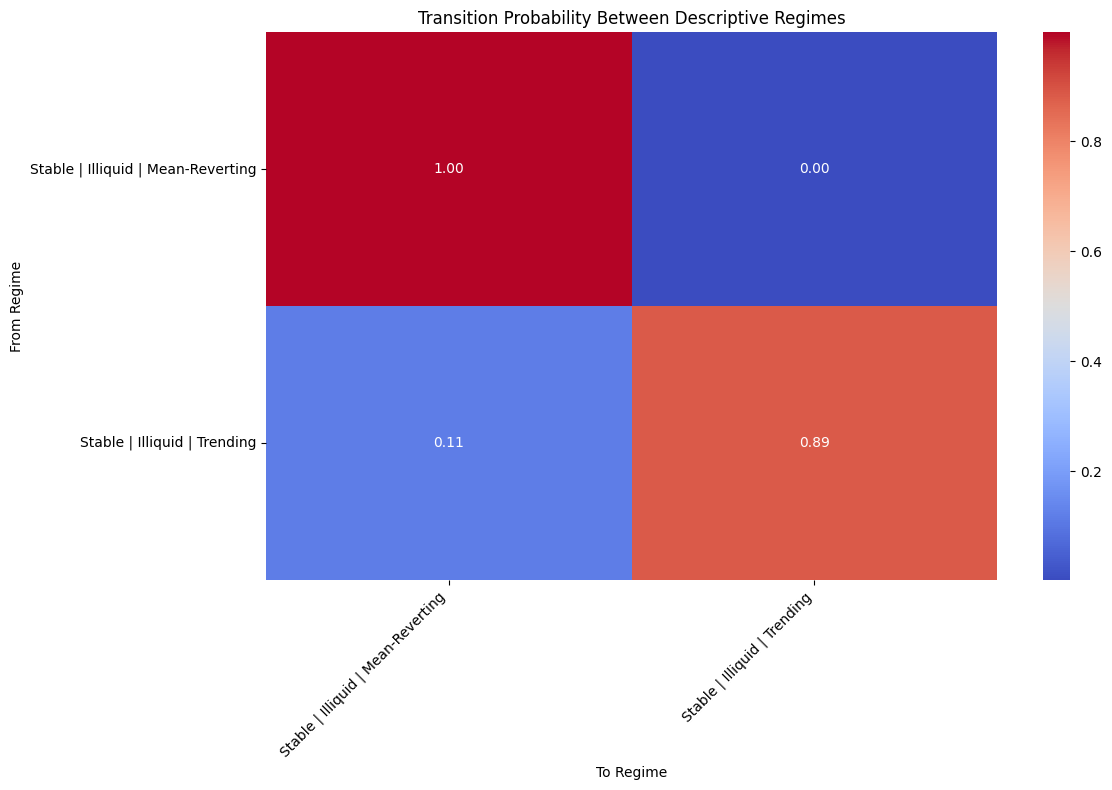


Top Regime Transitions (probability > 0.2):
Stable | Illiquid | Mean-Reverting → Stable | Illiquid | Mean-Reverting: 1.00
Stable | Illiquid | Trending → Stable | Illiquid | Trending: 0.89


In [13]:
# --- 12. REGIME CHANGE INSIGHTS (Transition Probabilities of Descriptive Regimes) ---
# Ensure regime_desc exists and is in string format
features['regime_desc'] = features['regime_desc'].astype(str)

# Create transition matrix using shifted regime descriptions
regime_transition_matrix = pd.crosstab(
    features['regime_desc'].shift(),
    features['regime_desc'],
    normalize='index'
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(regime_transition_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Transition Probability Between Descriptive Regimes')
plt.xlabel('To Regime')
plt.ylabel('From Regime')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Show top transitions (sorted)
print("\nTop Regime Transitions (probability > 0.2):")
for from_regime, row in regime_transition_matrix.iterrows():
    for to_regime, prob in row.items():
        if prob > 0.2:
            print(f"{from_regime} → {to_regime}: {prob:.2f}")


In [14]:
# --- 13. EXPORT TO CSV ---
# Create a timestamp column (assuming depth_data has a timestamp column)
if 'timestamp' in depth_data.columns:
    features['timestamp'] = pd.to_datetime(depth_data['timestamp'])
else:
    features['timestamp'] = np.arange(len(features))  # fallback index if no timestamp

# Reorder columns: timestamp, all features, regime, regime_desc
cols = ['timestamp'] + [col for col in features.columns if col not in ['timestamp', 'regime', 'regime_desc']] + ['regime', 'regime_desc']
features_export = features[cols]

# Export CSV (adjust file name/path as needed)
features_export.to_csv('BNBFDUSD_20250314_regime_features.csv', index=False)

print("Exported enriched features with regime labels to CSV.")


Exported enriched features with regime labels to CSV.
